<a href="https://colab.research.google.com/github/Rishita32/Kaggle-Machine-Learning-Practice/blob/main/Financial_News_Sentiment_Analysis_RNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from google.colab import drive

# Import Dataset

In [2]:
drive.mount('/content/drive', force_remount=True)
data=pd.read_csv('drive/MyDrive/Machine Learning Practice/datasets/financial_news.csv', encoding='latin1', nrows=100)

Mounted at /content/drive


In [3]:
data.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [4]:
data.shape

(100, 2)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 2 columns):
 #   Column                                                                                                                           Non-Null Count  Dtype 
---  ------                                                                                                                           --------------  ----- 
 0   neutral                                                                                                                          100 non-null    object
 1   According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .  100 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


# Data Preprocessing

In [6]:
data=data.rename(columns={'neutral':'sentiment','According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'news'})

In [7]:
data.head()

,sentiment,news
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


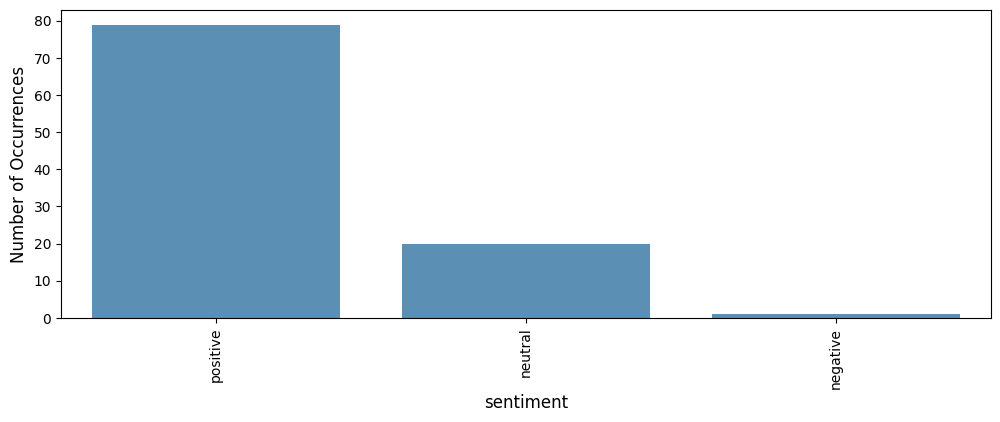

In [8]:
#check class imbalance

count=data['sentiment'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(x=count.index, y= count.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('sentiment', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [9]:
data['sentiment'].replace({"neutral":2, "positive": 1, "negative":0}, inplace=True)
data.head()

,sentiment,news
0,2,Technopolis plans to develop in stages an area...
1,0,The international electronic industry company ...
2,1,With the new production plant the company woul...
3,1,According to the company 's updated strategy f...
4,1,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


In [10]:
import re
def remove_number(text):
  return re.sub('[0-9+]', '', text)

def remove_htmltags(text):
  return re.sub(r'<[^>]+>', '', text)

def remove_symbols(text):
  return re.sub("[!@#$%^&*(){}£\/'']",'',text)

def make_lowercase(text):
  return text.lower()


In [11]:
data['news']=data['news'].apply(lambda x: remove_number(x))
data['news']=data['news'].apply(lambda x: remove_htmltags(x))
data['news']=data['news'].apply(lambda x: remove_symbols(x))
data['news']=data['news'].apply(lambda x: make_lowercase(x))

In [12]:
data['news'][1]

'the international electronic industry company elcoteq has laid off tens of employees from its tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily postimees reported .'

## Word to Tokens

In [13]:
import en_core_web_sm
nlp=en_core_web_sm.load()

def tokenize(text):
  doc=nlp(text)
  filtered_tokens=[]
  for token in doc:
    if token.is_stop or token.is_punct:
      continue
    filtered_tokens.append(token.lemma_)
  return ' '.join(filtered_tokens)


In [14]:
data['news']=data['news'].apply(tokenize)

In [15]:
data['news'][1]

'international electronic industry company elcoteq lay ten employee tallinn facility contrary early layoff company contract rank office worker daily postimee report'

## Tokens to Embeddings

In [16]:
# Note: We should always first split the data before creating embeddings otherwise we would be incurring data leakage and hiding the out-of-vocablury problem
X=data['news']
y=data['sentiment']


In [17]:
!pip install gensim

As a rule of thumb, a dataset with less than 100,000 sentences may benefit from a lower-dimensional embedding (e.g., 50-100 dimensions), while a larger dataset may benefit from a higher-dimensional embedding (e.g., 200-300 dimensions)

In [18]:
from gensim.models import Word2Vec
embedding_dim=100

word2vec_train_data=list(map(lambda x: x.split(), X))

In [19]:
word2vec_train_data

[['technopoli',
  'plan',
  'develop',
  'stage',
  'area',
  'square',
  'meter',
  'order',
  'host',
  'company',
  'work',
  'computer',
  'technology',
  'telecommunication',
  'statement',
  'say'],
 ['international',
  'electronic',
  'industry',
  'company',
  'elcoteq',
  'lay',
  'ten',
  'employee',
  'tallinn',
  'facility',
  'contrary',
  'early',
  'layoff',
  'company',
  'contract',
  'rank',
  'office',
  'worker',
  'daily',
  'postimee',
  'report'],
 ['new',
  'production',
  'plant',
  'company',
  'increase',
  'capacity',
  'meet',
  'expect',
  'increase',
  'demand',
  'improve',
  'use',
  'raw',
  'material',
  'increase',
  'production',
  'profitability'],
 ['accord',
  'company',
  's',
  'update',
  'strategy',
  'year',
  'basware',
  'target',
  'long',
  'term',
  'net',
  'sale',
  'growth',
  'range',
  'operate',
  'profit',
  'margin',
  'net',
  'sale'],
 ['financing',
  'aspocomp',
  's',
  'growth',
  'aspocomp',
  'aggressively',
  'pursue',
 

In [20]:
word2vec_model = Word2Vec(word2vec_train_data,
                 vector_size=embedding_dim,
                 workers=8,
                 min_count=5)

print("Vocabulary Length:", len(word2vec_model.wv.key_to_index))

Vocabulary Length: 65


In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
input_length=60
vocab_length=65

In [23]:
tokenizer=Tokenizer(num_words=vocab_length)
tokenizer.fit_on_texts(data['news'])
X=pad_sequences(tokenizer.texts_to_sequences(X), maxlen=input_length)
y=np.array(data['sentiment'])

In [24]:
X=np.asarray(X).astype(np.float32)
y=np.asarray(y).astype(np.float32)

In [25]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)

In [26]:
embedding_dim=100

model=Sequential()
model.add(Embedding(vocab_length, embedding_dim))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 8
batch_size = 264


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         6500      
                                                                 
 spatial_dropout1d (Spatial  (None, None, 100)         0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87001 (339.85 KB)
Trainable params: 87001 (339.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/8
1/1 [==============================] - 14s 14s/step - loss: 0.6906 - accuracy: 0.4625 - val_loss: 0.6634 - val_accuracy: 0.8500
Epoch 2/8
1/1 [==============================] - 1s 696ms/step - loss: 0.6648 - accuracy: 0.7750 - val_loss: 0.6380 - val_accuracy: 0.8500
Epoch 3/8
1/1 [==============================] - 1s 667ms/step - loss: 0.6343 - accuracy: 0.7750 - val_loss: 0.6088 - val_accuracy: 0.8500
Epoch 4/8
1/1 [==============================] - 1s 611ms/step - loss: 0.5985 - accuracy: 0.7750 - val_loss: 0.5730 - val_accuracy: 0.8500
Epoch 5/8
1/1 [==============================] - 0s 480ms/step - loss: 0.5602 - accuracy: 0.7750 - val_loss: 0.5265 - val_accuracy: 0.8500
Epoch 6/8
1/1 [==============================] - 0s 490ms/step - loss: 0.5101 - accuracy: 0.7750 - val_loss: 0.4622 - val_accuracy: 0.8500
Epoch 7/8
1/1 [==============================] - 0s 493ms/step - loss: 0.4336 - accuracy: 0.7750 - val_loss: 0.3678 - val_accuracy: 0.8500
Epoch 8/8
1/1 [=============

In [31]:
embedding_dim=100

model=Sequential()
model.add(Embedding(vocab_length, embedding_dim))
model.add(SpatialDropout1D(0.2))
model.add(SimpleRNN(2, input_shape=(2,1), activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 8
batch_size = 264


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         6500      
                                                                 
 spatial_dropout1d_3 (Spati  (None, None, 100)         0         
 alDropout1D)                                                    
                                                                 
 simple_rnn (SimpleRNN)      (None, 2)                 206       
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 6709 (26.21 KB)
Trainable params: 6709 (26.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/8
1/1 [==============================] - 2s 2s/step - loss: 0.6921 - accuracy: 0.2500 - val_loss: 0.6911 - val_accuracy: 0.8000
Epoch 2/8
1/1 [==============================] - 0s 90ms/step - loss: 0.6909 - accuracy: 0.6250 - val_loss: 0.6901 - val_accuracy: 0.8500
Epoch 3/8
1/1 [==============================] - 0s 96ms/step - loss: 0.6896 - accuracy: 0.7625 - val_loss: 0.6891 - val_accuracy: 0.8500
Epoch 4/8
1/1 [==============================] - 0s 100ms/step - loss: 0.6886 - accuracy: 0.7500 - val_loss: 0.6881 - val_accuracy: 0.8500
Epoch 5/8
1/1 [==============================] - 0s 234ms/step - loss: 0.6868 - accuracy: 0.7625 - val_loss: 0.6870 - val_accuracy: 0.8500
Epoch 6/8
1/1 [==============================] - 0s 209ms/step - loss: 0.6859 - accuracy: 0.7750 - val_loss: 0.6860 - val_accuracy: 0.8500
Epoch 7/8
1/1 [==============================] - 0s 193ms/step - loss: 0.6842 - accuracy: 0.7750 - val_loss: 0.6849 - val_accuracy: 0.8500
Epoch 8/8
1/1 [=================